# 0.0 IMPORTS


In [1]:
import math
import datetime
import inflection

import numpy               as np
import pandas              as pd
#import xgboost             as xgb
import matplotlib.pyplot   as plt
import seaborn             as sns
import matplotlib.gridspec as gridspec

from scipy                 import stats     as ss
from boruta                import BorutaPy
from IPython.display       import Image
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 Helper Functions

In [2]:
def cramer_v(x,y):
    
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    
    
    chi2corr = max(0 ,chi2 - (k-1)* (r-1)/(n-1))
    kcorr = k - (k-1)** 2 /(n-1)
    rcorr = r - (r-1)** 2 /(n-1)
    
    
    return np.sqrt ( ( chi2corr/n)/(min( kcorr-1,rcorr-1))) 

In [3]:
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs(( y - yhat ) / y ))

def ml_error (model_name, y, yhat):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ))
    
    return pd.DataFrame({ 'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index = [0])

### 0.2 Loading Data

In [4]:
df_sales_raw= pd.read_csv('Data/train.csv',low_memory=False)
df_store_raw= pd.read_csv('Data/store.csv',low_memory=False)

#merge
df_raw  = pd.merge(df_sales_raw,df_store_raw,how='left',on='Store')

# 1.0 DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

In [6]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1. Rename Columns

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase= lambda x : inflection .underscore(x)

cols_new= list(map( snakecase, cols_old ))

#  Rename
df1.columns= cols_new

## 1.2. Data Dimension

In [8]:
print( 'number of rows: {}'.format( df1.shape[0]))
print( 'number of columns: {}'.format( df1.shape[1]))

number of rows: 1017209
number of columns: 18


## 1.3. Data Type

In [9]:
df1['date']= pd.to_datetime(  df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
#competition_distance 

df1['competition_distance']= df1['competition_distance'].apply(lambda x:  200000.0 if math.isnan (x) else x)

#competition_open_since_month  

df1['competition_open_since_month']=df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)


#competition_open_since_year     

df1['competition_open_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)


#promo2_since_week 


df1['promo2_since_week']=df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)


#promo2_since_year


df1['promo2_since_year']=df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)


#promo_interval

month_map={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map']=df1['date'].dt.month.map(month_map) 

df1['is_promo']=df1[['promo_interval','month_map']].apply( lambda x:0 if x['promo_interval']== 0 
                                                          else 1 if x ['month_map'] in x ['promo_interval'].split(',') else 0 , axis= 1 )




In [12]:
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0


In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [14]:
df1['competition_open_since_month']= df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']= df1['competition_open_since_year'].astype(int)

df1['promo2_since_week']= df1['promo2_since_week'].astype(int)
df1['promo2_since_year']= df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Estatistical

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
num_attributes= df1.select_dtypes(include = ['int64', 'int32', 'float64'])

cat_attributes= df1.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

## 1.7.1  Numerical Attributes

In [17]:
# Central tendency - mean, median


ct1=pd.DataFrame(num_attributes.apply(np.mean) ).T
ct2=pd.DataFrame(num_attributes.apply(np.median) ).T


# Dispersion - std, min, max, range, skew, kurtosis

d1=pd.DataFrame(num_attributes.apply (np.std) ).T
d2=pd.DataFrame(num_attributes.apply (min ) ).T
d3=pd.DataFrame(num_attributes.apply (max ) ).T
d4=pd.DataFrame(num_attributes.apply(lambda x: x.max()  - x.min()  ) ).T
d5=pd.DataFrame(num_attributes.apply(lambda x: x.skew ( )  )  ).T
d6=pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis () )  ).T


#concatenate

m= pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()

m.columns= ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [18]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


D:\anaconda3\envs\Projeto Rossman\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

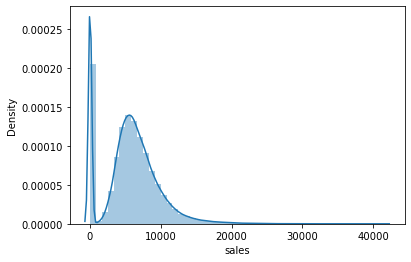

In [19]:
sns.distplot( df1['sales'])

## 1.7.1  Categorical Attributes

In [20]:
cat_attributes.apply (lambda x : x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

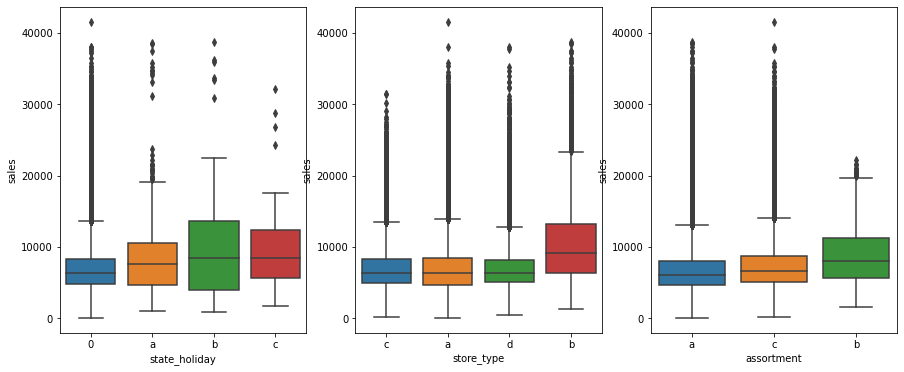

In [21]:
aux1=df1[(df1['state_holiday']!=0 ) & (df1['sales'] > 0)]

plt.figure(figsize=(15,6))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales',data=aux1 )

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales',data=aux1 )

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales', data=aux1)



# 2.0. FEATURE ENGINEERING 

In [22]:
df2 = df1.copy()

## 2.1. HYPOTHESES MIND MAP

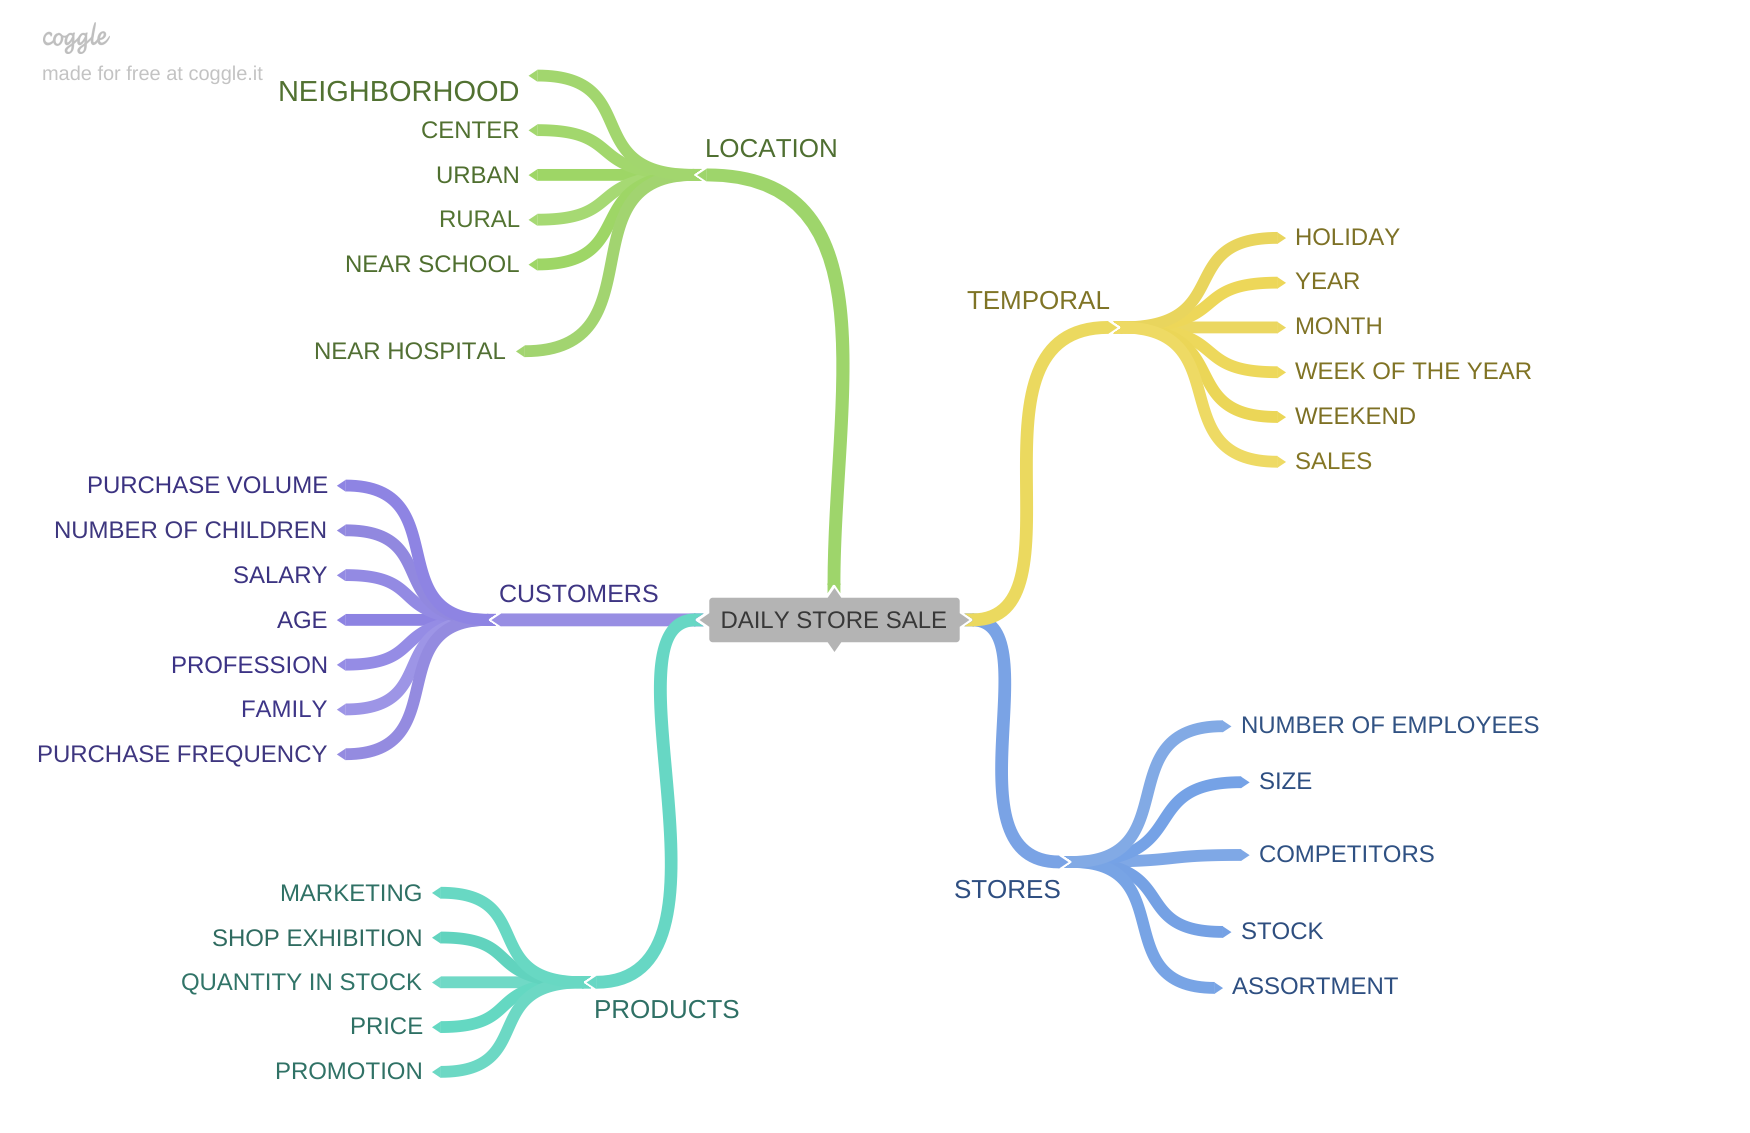

In [23]:
Image ('img/MIND_MAP_HYPOTESIS_DAILY_STORE_SALE.png')

## 2.2 CREATION OF HYPOTHESES

### 2.2.1 HYPOTESES SHOP 

**1.** Larger stores should sell more

**2.** Stores with a larger staff should sell more

**3.** Stores with fewer competitors should sell more.

**4.** Stores with a larger stock should sell more.

**5.** Stores with a larger assortment should sell more.

**6.** Stores with longer competitors should sell more. 

### 2.2.2 HYPOTESES PRODUCTS

**1.** Stores with a greater marketing should sell more.

**2.** Stores that exhibit more product sell more.

**3.** Stores with a fewer price shoul sells more.

**4.** Stores with a fewer price for longer should sell more. 

**5.** Stores whith extended promotion should sell more.

**6.** Stores with consecutive promotions should sell more.




### 2.2.3 HYPOTESES TEMPORAL

**1.** Stores with more holydays should sell less.

**2.** Stores that open in the first 6 months should sell more.

**3.** Stores that open on wekkend should sell more.

**4.** Stores should sell more after 10 day of the month.

**5.** Stores should sell less during scool holidays.

**7.** Stores should sell more over the years.

**8.** Stores that open on Christmas should sell more.

**9.** Stores should sell less during wekkend.

**10.** Stores should sell more in the second half in the year.

## 2.3. Final list of hypotheses

**1.** Stores with a larger assortment should sell more.

**2.** H2.Stores with closer competitors should sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with fewer competitors should sell more.

**5.** Stores whith extended promotion should sell more.

**6.** Stores with consecutive promotions should sell more.

**7.** Stores that open on Christmas should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half in the year.

**10.** Stores should sell more after 10 day of the month.

**11.** Stores should sell less during wekkend.

**12.** Stores should sell less during scool holidays.














## 2.4. FEATURE ENGINEERING

In [24]:
# YEAR
df2['year']=df2['date'].dt.year

# MONTH
df2['month']=df2['date'].dt.month    
    
# DAY
df2['day']=df2['date'].dt.day

# WEEK OF YEAR
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# YEAR WEEK
df2['year_week']=df2['date'].dt.strftime('%Y-%W')

# COMPETITION SINCE
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month = x['competition_open_since_month'] ,day = 1), axis = 1)         
df2['competition_time_month']=(( df2['date'] - df2['competition_since']) / 30 ).apply( lambda x: x.days).astype(int)

# PROMO SINCE

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x:datetime.datetime.strptime(x + '-1','%Y-%W-%w')

                                              - datetime.timedelta( days= 7 ))
df2['promo_time_week'] = ( ( df2['date']-df2['promo_since'] ) / 7  ).apply (lambda x: x.days).astype ( int )

#df2['promo_time_week'] = ( ( df2['date']-df2['promo_since'] ) / 7  ).apply (lambda x: x.days).astype ( int )


#ASSORTMENT

df2['assortment'] = df2['assortment'].apply(lambda x:  'basic' if x == 'a' else 'extra' if x == 'b' else 'extended') 

#STATE HOLIDAY

df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' 
                                                  if x == 'b' else 'christmas' if x =='c' else 'regular_day')



# 3.0. FILTERING VARIABLES

In [25]:
df3= df2.copy()

## 3.1.  LINE FILTERING

In [26]:
df3 =df3[ ( df3['open']  != 0 ) & ( df3['sales']  > 0 )] 

## 3.2. COLOMN SELECTION

In [27]:
cols_drop = ['customers','open','promo_interval','month_map']
df3= df3.drop(cols_drop,axis=1)

# 4.0.EXPLORATORY DATA ANALYSIS

In [28]:
df4 = df3.copy()

## 4.1. UNIVARIATE ANALYSIS

### 4.1.1. Responde variable

D:\anaconda3\envs\Projeto Rossman\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

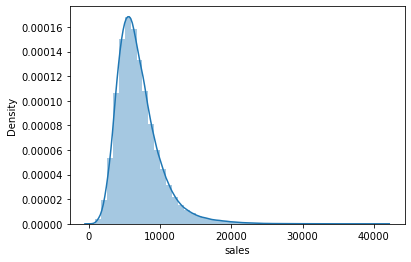

In [29]:
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

D:\anaconda3\envs\Projeto Rossman\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


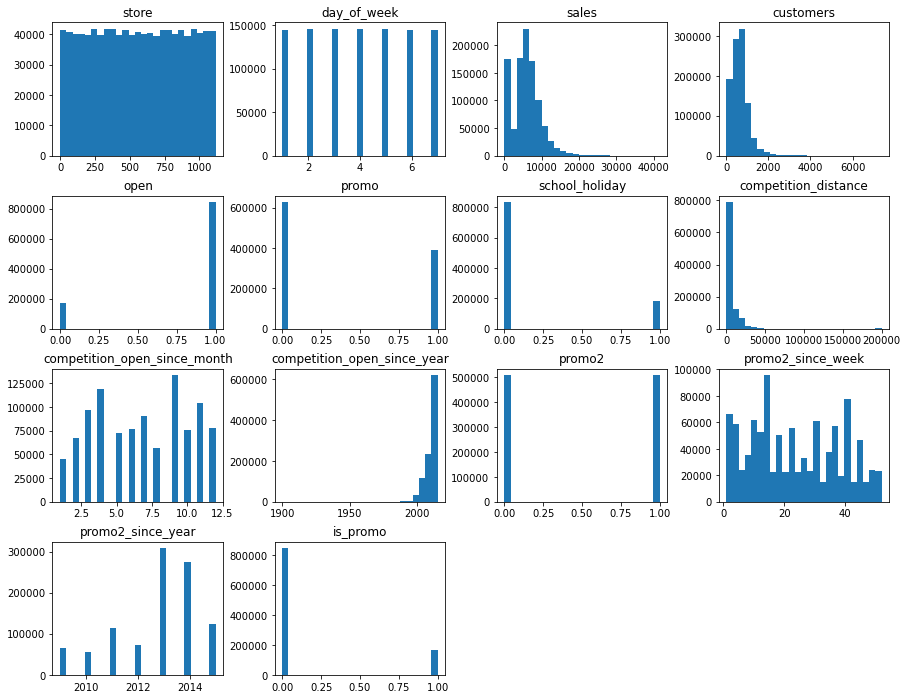

In [30]:
fig = plt.figure(figsize = (15,12))
num_attributes.hist(bins = 25, ax = fig.gca(), grid = False);

### 4.1.3. Caregorical Variable

In [31]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [32]:
df4['store_type'].drop_duplicates()
df4['state_holiday'].drop_duplicates()
df4['assortment'].drop_duplicates()


0         basic
3      extended
258       extra
Name: assortment, dtype: object

D:\anaconda3\envs\Projeto Rossman\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\anaconda3\envs\Projeto Rossman\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\anaconda3\envs\Projeto Rossman\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='sales', ylabel='Density'>

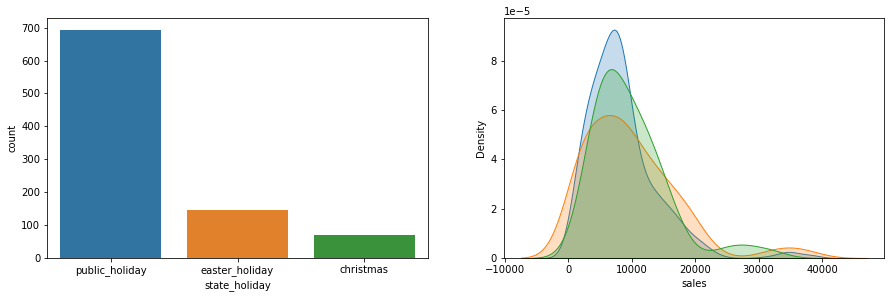

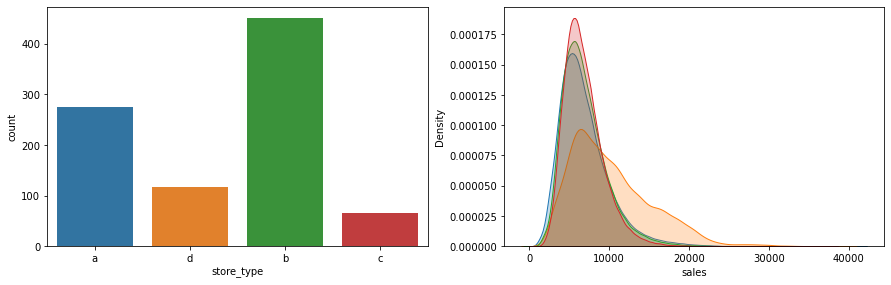

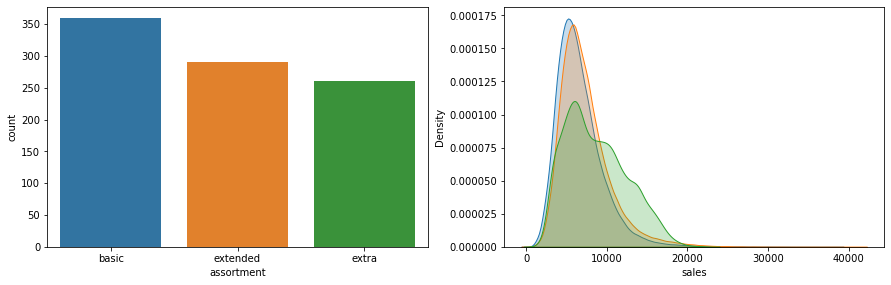

In [33]:
# state_holiday

plt.figure(figsize=(15,15))


plt.subplot( 3,2,1)
a= df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot( 3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday'] ['sales'],label = 'public holiday',shade= True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday'] ['sales'],label = 'public holiday',shade= True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas'] ['sales'],label = 'public holiday',shade= True )

#store_type
plt.figure(figsize=(15,15))

plt.subplot( 3,2,3)
sns.countplot(a['store_type'])

plt.subplot( 3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a'] ['sales'],label = 'a',shade= True )
sns.kdeplot( df4[df4['store_type'] == 'b'] ['sales'],label = 'b',shade= True )
sns.kdeplot( df4[df4['store_type'] == 'c'] ['sales'],label = 'c',shade= True )
sns.kdeplot( df4[df4['store_type'] == 'd'] ['sales'],label = 'd',shade= True )

#assortment
plt.figure(figsize=(15,15))

plt.subplot( 3,2,5)
sns.countplot(a['assortment'])

plt.subplot( 3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'basic'] ['sales'],label = 'basic',shade= True )
sns.kdeplot( df4[df4['assortment'] == 'extended'] ['sales'],label = 'extended',shade= True )
sns.kdeplot( df4[df4['assortment'] == 'extra'] ['sales'],label = 'extra',shade= True )



## 4.2. BIVARIATE ANALYSIS

### H1. Stores with a larger assortment should sell more.

**False** The sum of stores with greater assortments is less.


Text(0.5, 1.0, 'Sales Mean')

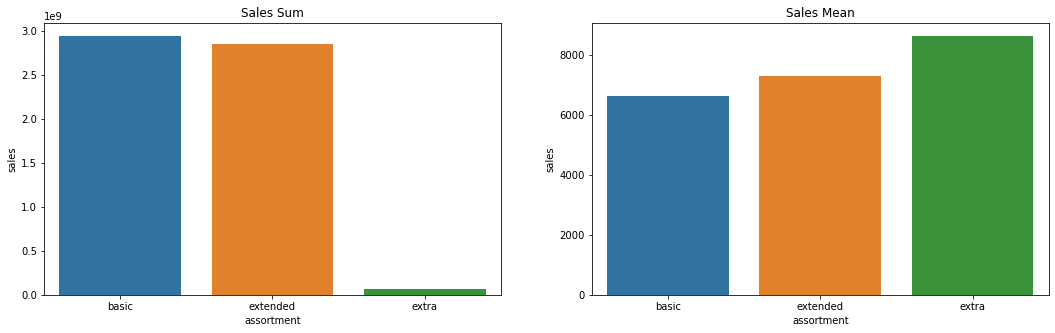

In [34]:
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
aux1 = df4[['assortment','sales']].groupby( 'assortment').sum().reset_index()
sns.barplot ( x = 'assortment', y = 'sales', data= aux1);
plt.title('Sales Sum')

#plt.figure(figsize=(10,5))

plt.subplot(1,2,2)

aux1 = df4[['assortment','sales']].groupby( 'assortment').mean().reset_index()
sns.barplot ( x = 'assortment', y = 'sales', data= aux1);
plt.title('Sales Mean')





<AxesSubplot:xlabel='year_week'>

<Figure size 1296x360 with 0 Axes>

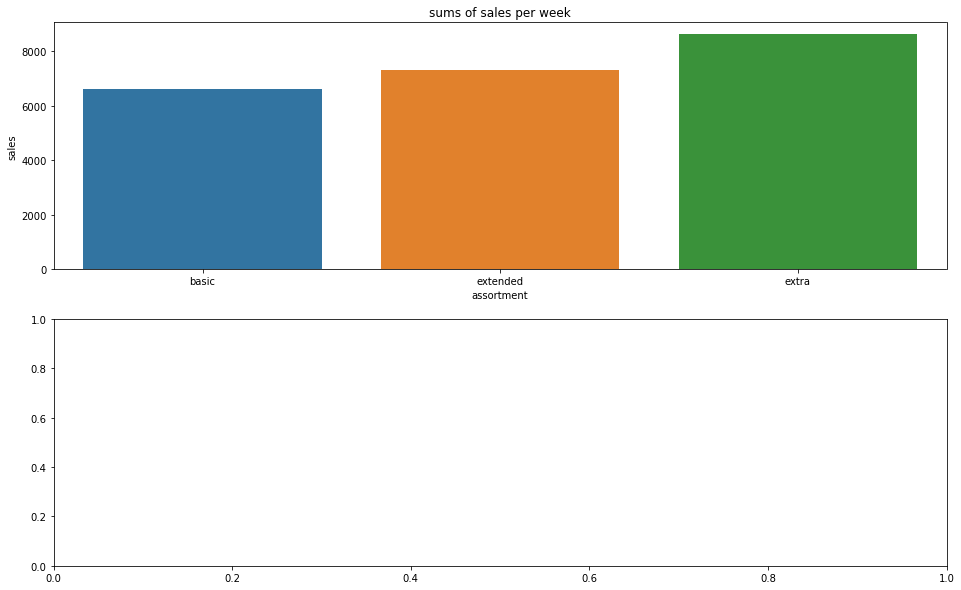

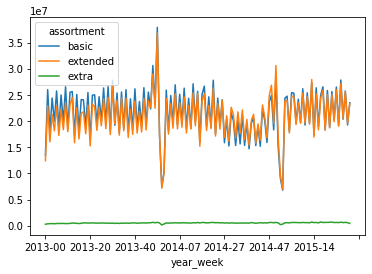

In [35]:
plt.figure(figsize=(18,5))
fig = plt.figure(figsize = (16,10))
grid = gridspec.GridSpec(2,2)


plt.subplot (grid[0,:])
aux2 = df4[['year_week','assortment','sales']].groupby(['year_week', 'assortment']).sum().reset_index()
sns.barplot ( x = 'assortment', y = 'sales', data= aux1);
plt.title('sums of sales per week')


plt.subplot (grid[1,:])
aux2.pivot ( index= 'year_week', columns = 'assortment',values = 'sales'  ).plot()

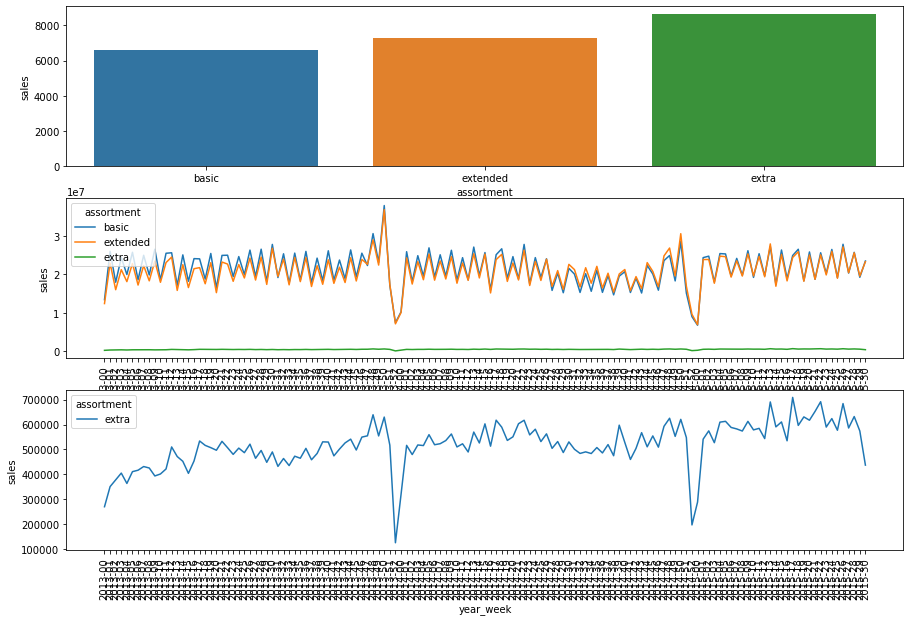

In [36]:
fig = plt.figure(figsize = (15,10))

plt.subplot (3,1,1)
aux1 = df4[['assortment', 'sales']].groupby('assortment').mean().reset_index()
sns.barplot (x = 'assortment', y = 'sales', data = aux1)

plt.subplot (3,1,2)
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
#aux2.pivot (index = 'year_week', columns = 'assortment', values = 'sales').plot()
sns.lineplot(x='year_week', y='sales', hue='assortment', data = aux2)
plt.xticks(rotation = 90);

plt.subplot (3,1,3)
aux3 = aux2 [ aux2['assortment'] == 'extra' ]
#aux2.pivot (index = 'year_week', columns = 'assortment', values = 'sales').plot()
sns.lineplot(x='year_week', y='sales', hue='assortment', data = aux3)
plt.xticks(rotation = 90);

### H2.Stores with closer competitors should sell less.

**False** Stores with competition closer  do not sell less, there not such relationship.

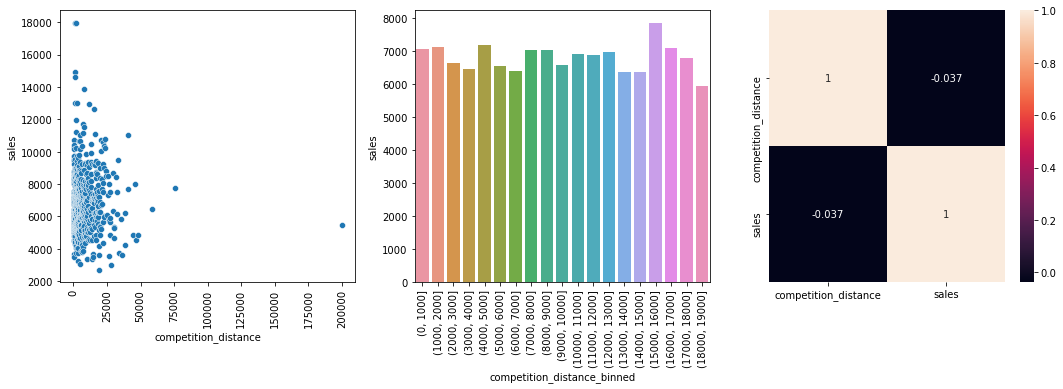

In [37]:
plt.figure(figsize=(18,5))

plt.subplot(1,3 ,1)
aux1 = df4[['competition_distance','sales']].groupby( 'competition_distance').mean().reset_index()
sns.scatterplot( x = 'competition_distance', y= 'sales', data = aux1)
plt.xticks ( rotation =90);

plt.subplot(1,3 ,2)
bins = list (np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins )
aux2 = aux1[['competition_distance_binned','sales']].groupby( 'competition_distance_binned').mean().reset_index()
sns.barplot ( x = 'competition_distance_binned',y ='sales' , data= aux2  );
plt.xticks ( rotation =90);

plt.subplot(1,3,3)
sns.heatmap( aux1.corr( method= 'pearson'), annot= True );


### H3. Stores with longer competitors should sell more.

**False** Stores with longer competitor do not sell more.

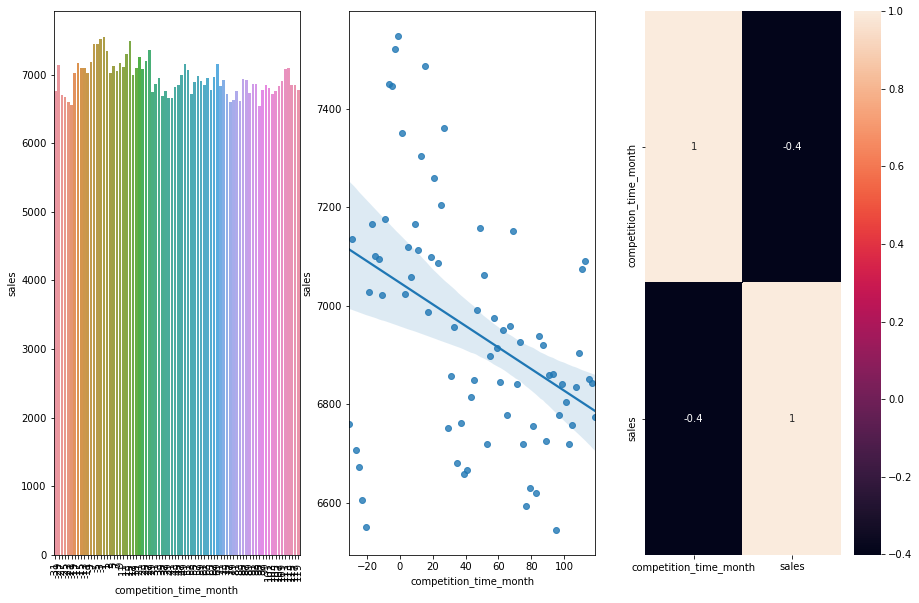

In [38]:
fig = plt.figure( figsize = (15,10))


plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby( 'competition_time_month').mean().reset_index()
aux2 =  aux1[ (aux1['competition_time_month'] < 120) & ( aux1['competition_time_month']) != 0] 

sns.barplot( x='competition_time_month', y = 'sales', data = aux2 )
plt.xticks(rotation = 90 );

plt.subplot(1,3,2)
sns.regplot( x='competition_time_month', y = 'sales', data = aux2 )

plt.subplot(1,3,3)
sns.heatmap( aux2.corr ( method = 'pearson'), annot = True);


### H4 Stores whith extended promotion should sell more.

**False** Because stores with active promotions for longer do not sell anymore.



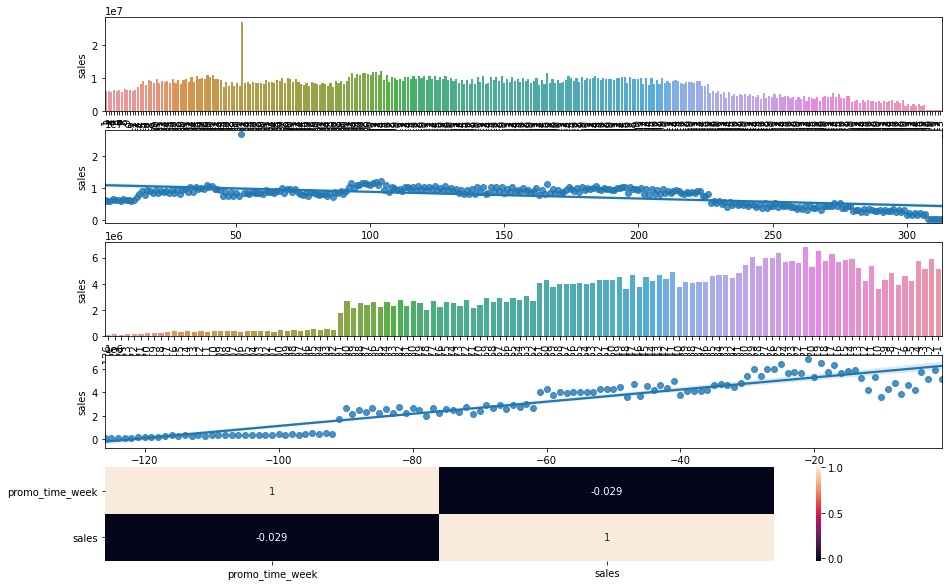

In [39]:
fig = plt.figure( figsize = (15,10))

aux1 = df4[[ 'promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

#sns.barplot(x ='promo_time_week' ,y = 'sales', data = aux1 );


plt.subplot( 5,1,1)
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extended
sns.barplot(x ='promo_time_week' ,y = 'sales', data = aux2 )
plt.xticks( rotation = 90);

plt.subplot( 5,1,2)
sns.regplot(x ='promo_time_week' ,y = 'sales', data = aux2 )


plt.subplot(5,1,3 )
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x ='promo_time_week' ,y = 'sales', data = aux3 )
plt.xticks(rotation = 90);



plt.subplot( 5,1,4)
sns.regplot(x ='promo_time_week' ,y = 'sales', data = aux3 )

plt.subplot( 5,1,5)
sns.heatmap( aux1.corr ( method= 'pearson'), annot=True);

### H5 Stores with consecutive promotions should sell more.

**False** Stores with consecutive promotions do not sell anymore.

In [40]:
df4[['promo','promo2','sales']].groupby ([ 'promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


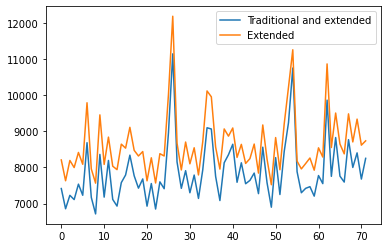

In [41]:
aux1 = df4 [( df4['promo'] == 1) & (df4['promo2'] == 1 )] [['year_week','sales']].groupby('year_week').mean().reset_index()

ax = aux1.plot()


aux2 = df4 [( df4['promo'] == 1) & (df4['promo2'] == 0 )] [['year_week','sales']].groupby('year_week').mean().reset_index()
aux2.plot(ax = ax)

ax.legend(labels = ['Traditional and extended','Extended']);

### **7** Stores that open on Christmas should sell more.

**False** Stores opened at Christmas sell less.


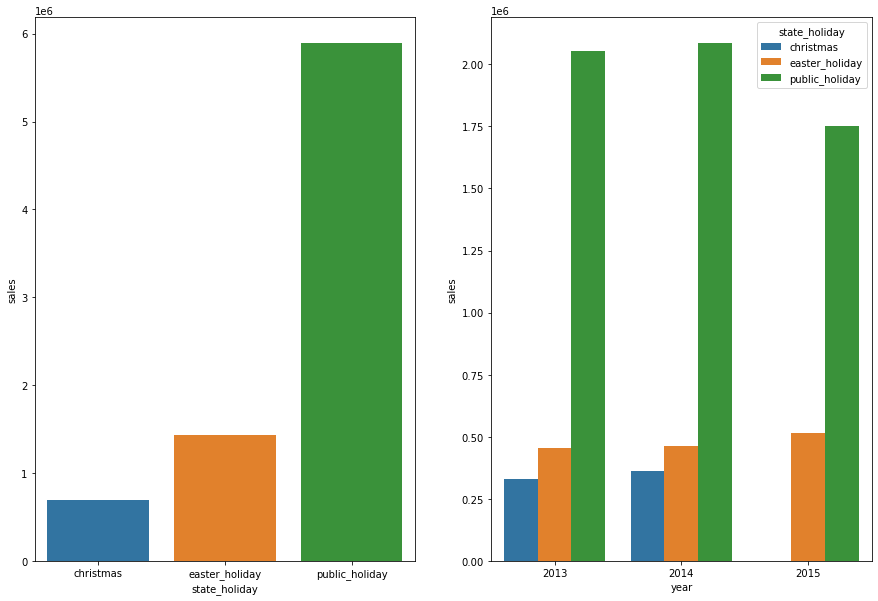

In [42]:
fig = plt.figure( figsize = (15,10))

aux = df4[df4['state_holiday'] != 'regular_day']


plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x= 'state_holiday',y = 'sales',data = aux1);


plt.subplot(1, 2, 2)
aux2 = aux [['year', 'state_holiday', 'sales']].groupby( [ 'year', 'state_holiday']).sum().reset_index()
sns.barplot(x= 'year' , y = 'sales', hue = 'state_holiday', data = aux2);

### **8**  Stores should sell more over the years.

**False** Stores no longer sell over the years



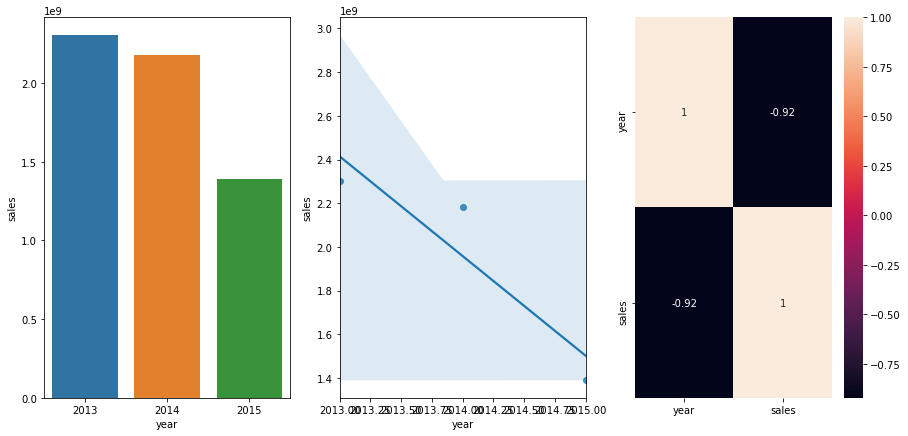

In [43]:
fig = plt.figure( figsize = (15,7))

aux1 =  df4[['year', 'sales']].groupby ( 'year').sum().reset_index()


plt.subplot( 1, 3, 1)
sns.barplot(x= 'year', y = 'sales', data= aux1 );


plt.subplot( 1, 3, 2)
sns.regplot(x= 'year', y = 'sales', data= aux1 );


plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot= True );

### **9** Stores should sell more in the second half in the year.

**False** Stores no longer sell in the second half.



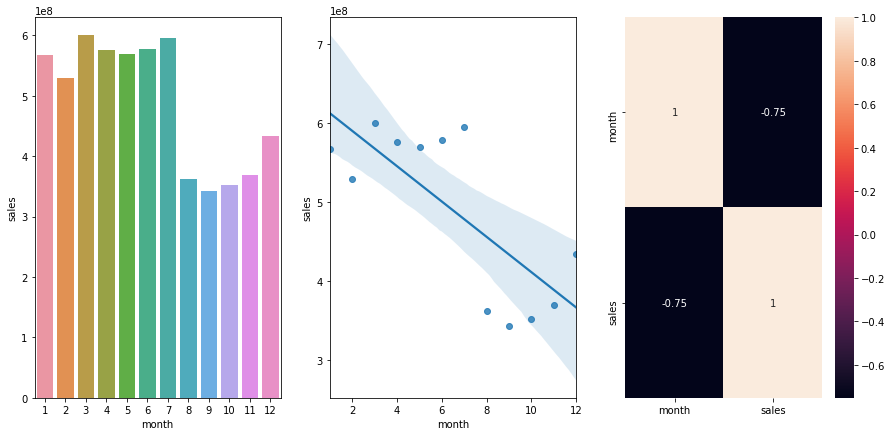

In [44]:
fig = plt.figure( figsize = (15,7))

aux1 =  df4[['month', 'sales']].groupby ('month').sum().reset_index()


plt.subplot( 1, 3, 1)
sns.barplot(x= 'month', y = 'sales', data= aux1 );


plt.subplot( 1, 3, 2)
sns.regplot(x= 'month', y = 'sales', data= aux1 );


plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot= True );

### **10** Stores should sell more after 10 day of the month.

**True** Stores must sell more after 10 days of the month.

<AxesSubplot:xlabel='before_after', ylabel='sales'>

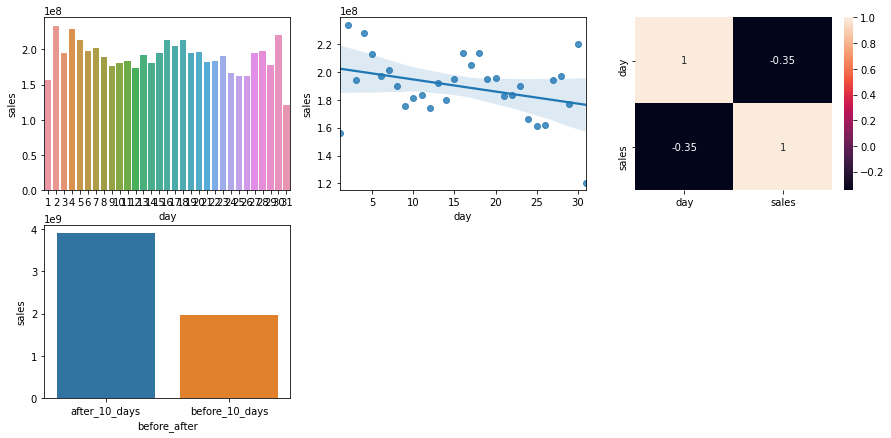

In [45]:
fig = plt.figure( figsize = (15,7))

aux1 =  df4[['day', 'sales']].groupby ('day').sum().reset_index()


plt.subplot( 2,3, 1)
sns.barplot(x= 'day', y = 'sales', data= aux1 );


plt.subplot( 2,3, 2)
sns.regplot(x= 'day', y = 'sales', data= aux1 );


plt.subplot( 2,3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot= True );

aux1 ['before_after'] = aux1 ['day'].apply (lambda x:'before_10_days' if x <= 10 else 'after_10_days')


plt.subplot( 2,3, 4)
aux2 =  aux1 [['before_after','sales']].groupby( 'before_after').sum().reset_index()
sns.barplot( x = 'before_after', y = 'sales', data= aux2)

### **11** Stores should sell less during wekkend.

**True** Stores sell less on the weekend.


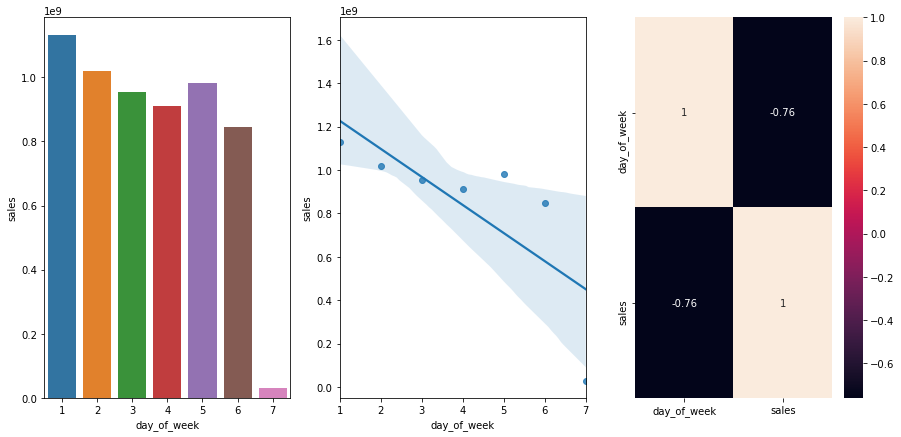

In [46]:
fig = plt.figure( figsize = (15,7))

aux1 =  df4[['day_of_week', 'sales']].groupby ( 'day_of_week').sum().reset_index()


plt.subplot( 1, 3, 1)
sns.barplot(x= 'day_of_week', y = 'sales', data= aux1 );


plt.subplot( 1, 3, 2)
sns.regplot(x= 'day_of_week', y = 'sales', data= aux1 );


plt.subplot( 1, 3, 3)
sns.heatmap(aux1.corr( method = 'pearson'), annot= True );

### **12** Stores should sell less during scool holidays.

**True** Stores sell less during school holidays, except during July and August.

<AxesSubplot:xlabel='month', ylabel='sales'>

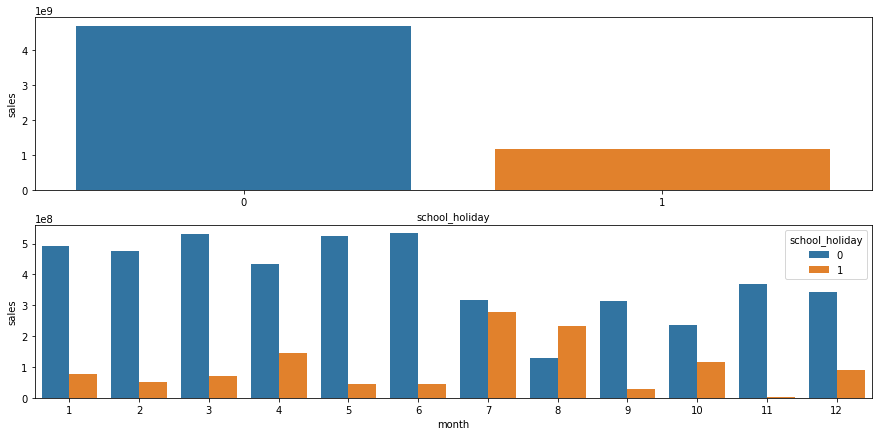

In [47]:
fig = plt.figure( figsize = (15,7))


plt.subplot( 2, 1 , 1 )
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot( x = 'school_holiday' , y = 'sales', data= aux1)


plt.subplot( 2, 1 , 2 )
aux2 = df4[['month','school_holiday','sales']].groupby(['month' ,'school_holiday']).sum().reset_index()
sns.barplot( x = 'month' , y = 'sales',hue= 'school_holiday', data= aux2)

### 4.2.1. Summary Of Hypotheses

In [48]:
from tabulate import tabulate

In [49]:
tab = [ ['Hypotheses','Conclusion','Relevance'],
        ['H1', 'False', 'Low' ],
        ['H2', 'False', 'Mean'],
        ['H3', 'False', 'Mean'],
        ['H4', 'false', 'Low' ],
        ['H5', '-', '-' ],
        ['H6','False', 'Low' ],
        ['H7', 'False', 'Mean' ],
        ['H8', 'False', 'High' ],
        ['H9', 'False', 'High' ],
        ['H10', 'True', 'High' ],
        ['H11', 'True', 'High' ],
        ['H12', 'True', 'Low' ],
       ]
        
print ( tabulate( tab ,headers = 'firtstrow'))        

f           i           r
----------  ----------  ---------
Hypotheses  Conclusion  Relevance
H1          False       Low
H2          False       Mean
H3          False       Mean
H4          false       Low
H5          -           -
H6          False       Low
H7          False       Mean
H8          False       High
H9          False       High
H10         True        High
H11         True        High
H12         True        Low


## 4.3. MULTIVARIATE ANALYSIS

### 4.3.Numerical Attributes

<AxesSubplot:>

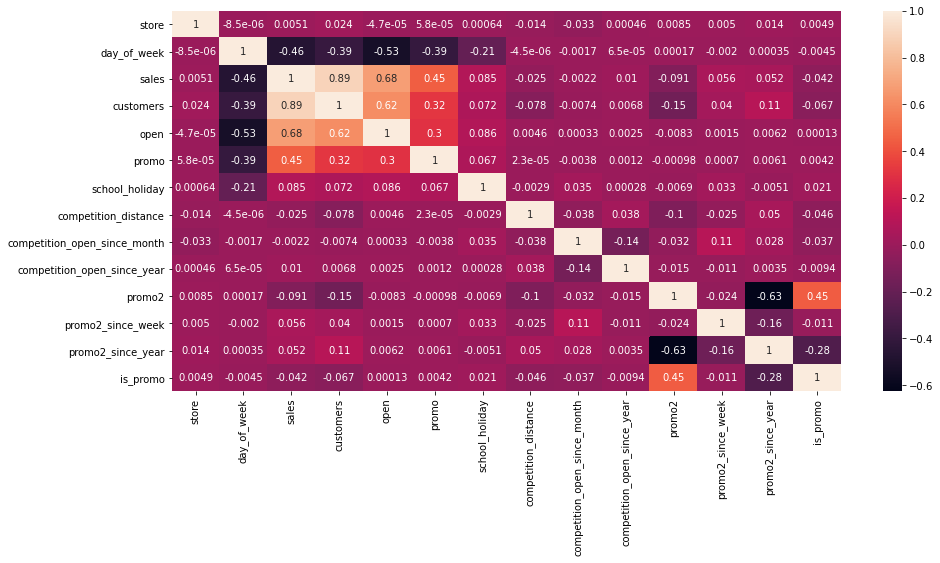

In [50]:
fig = plt.figure( figsize = (15,7))

correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap(correlation, annot = True)

### 4.3.2 Caregorical Attributes

<AxesSubplot:>

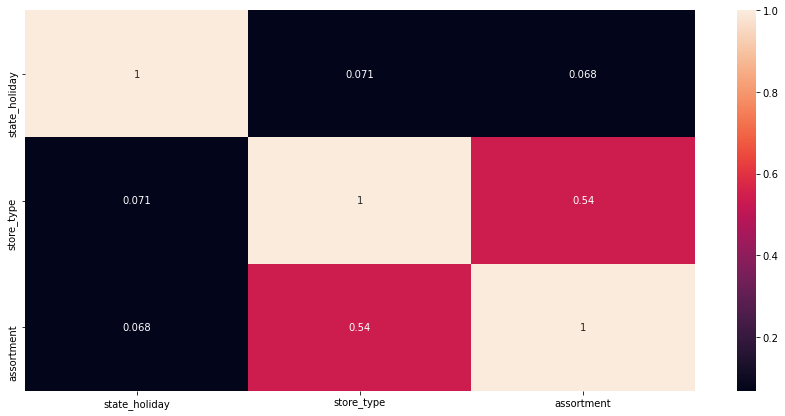

In [51]:
# Only categorical data
a = df4.select_dtypes ( include = 'object')

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )


a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )


a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

#Final dataset 
d = pd.DataFrame ({'state_holiday' : [a1,a2,a3],
                   'store_type'    : [a4,a5,a6],
                   'assortment'    : [a7,a8,a9]
                  })

d = d.set_index(d.columns)


fig = plt.figure( figsize = (15,7))

sns.heatmap (d, annot = True )

# 5.0. DATA PREPARATION

In [52]:
df5 = df4.copy()

## 5.1. Normalization

**None of the numerical variable have a normal distribution, thus the normalization it's not fit.** 

## 5.2 Rescaling

In [53]:
rs = RobustScaler ()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )


# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )



# year
df5['year'] = mms.fit_transform( df5[['year']].values )



## 5.3. Transformation

### 5.3.1. Encoding

In [54]:
# State holiday - One Hot Encoding
df5 = pd.get_dummies ( df5, prefix = ['state_holiday'], columns = [ 'state_holiday'])

# Store type - Label Encoding
le = LabelEncoder ()

df5 ['store_type'] = le.fit_transform ( df5 ['store_type'])

# Assortment - Ordinal Encoding
assortment_dict= {'basic': 1,
                  'extra': 2,
                  'extended': 3 ,
                 }

df5['assortment'] = df5 ['assortment'].map (assortment_dict)

### 5.3.2 Response Variable Transformation

In [55]:
df5 ['sales'] = np.log1p(df5['sales'])

D:\anaconda3\envs\Projeto Rossman\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

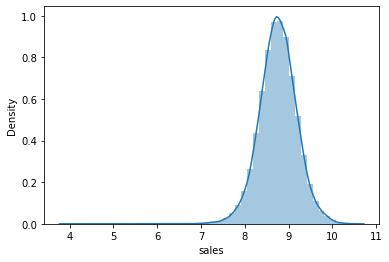

In [56]:
sns.distplot (df5['sales'])

### 5.3.2. Nature Transformation

In [57]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply ( lambda x :np.sin ( x * ( 2 * np.pi /7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply ( lambda x :np.cos ( x * ( 2 * np.pi /7 ) ) )

# month
df5['month_sin'] = df5['month'].apply ( lambda x :np.sin ( x * ( 2 * np.pi /12 ) ) )
df5['month_cos'] = df5['month'].apply ( lambda x :np.cos ( x * ( 2 * np.pi /12 ) ) )

# day
df5['day_sin'] = df5['day'].apply ( lambda x :np.sin ( x * ( 2 * np.pi /30 ) ) )
df5['day_cos'] = df5['day'].apply ( lambda x :np.cos ( x * ( 2 * np.pi /30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply ( lambda x :np.sin ( x * ( 2 * np.pi /52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply ( lambda x :np.cos ( x * ( 2 * np.pi /52 ) ) )


# 6.0. FEATURE SELECTION

In [58]:
df6  = df5.copy()

## 6.1. Split Dataframe into Training and Test Dataset

In [59]:
cols_drop = [ 'week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop ( cols_drop, axis = 1)

In [60]:
df6 [ [ 'store', 'date']].groupby('store').max().reset_index()['date'][0] -datetime.timedelta( days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [61]:
# Training dataset

X_train = df6 [df6 [ 'date'] < '2015-06-19']
y_train = X_train['sales']


# Test dataset

X_test = df6 [df6 [ 'date'] > '2015-06-19']
y_test = X_test['sales']


## 6.2. Boruta as Feature Selector

In [62]:
# Training and test for Boruta
#X_train_n = X_train.drop( [ 'date','sales'], axis = 1).values
#y_train_n = y_trains.values.ravel ()

# Define RandomForestRegressor
#rf = RandomForestRegressor ( n_jobs = -1)



# Define Boruta
#borutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit ( X_train_n, y_train_n)

### 6.2.1 Best Features from Boruta

In [63]:
#cols_selected = boruta.support_.tolist()


# Best Features
#X_train_fs = X_train.drop ( ['date','sales'], axis = 1)
#cols_selected_boruta =  X_train_fs.iloc [ : , cols_selected].columns.to_list()


# Not selected Boruta
#cols_not_selected_boruta =  list( np. setdiff1d (X_train_fs.columns , cols_selected_boruta))

## 6.3 Manual Feature Selection

In [64]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_sin',
                        'day_cos',
                        'month_cos',
                        'month_sin',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'week_of_year_sin',
                        'week_of_year_cos']

# Columns to add
feat_to_add = ['date', 'sales']

# Final Features
#cols_selected_boruta.extend(feat_to_add)

# 7.0. MACHINE LEARNING MODEL

In [65]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1. Average Model

In [66]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#Prediction
aux2 =  aux1[[ 'store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales' : 'predictions'})
aux1 = pd.merge (aux1, aux2, how = 'left', on='store')
yhat_baseline = aux1[ 'predictions' ]

#Performace
baseline_result = ml_error( 'Avarege Model', np.expm1( y_test),np.expm1(yhat_baseline))

baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarege Model,1366.128351,0.452087,1854.263316
